# Biodiversity Intactness Index change in Phoenix subdivision
Author: Patricia Park
Github repository can be access here: https://github.com/p-park6/biodiversity-index-phoenix


# Preliminary information
This notebook covers the biodiversity intactness index (BII), specifically in Maricopa County, which is in the Phoenix metropolitan area. Over 270 square miles have been converted into developed land since 2001 [^1]. One potential impact that increased urban sprawl has is how it is impacting the biodiversity and natural areas. This notebook will be looking at the potential impacts increased developed land has on the BII.


## Notebook Highlights
- Fetching data from the Microsoft Planetary Computer STAC catalog
- Creating an overlay of Phoenix county on a basemap
- Calculating percentage of area with a BII of over 0.75
- Creating a visualization of lost BII over 0.75 from 2017 to 2020


## Datasets information

### Dataset 1
The first dataset that I will be using is from the Microsoft Planetary Computer STAC API, which houses the needed geospatial data we will use in this notebook. This dataset houses multiple data catalog ranging from air quality to infrastructure. For this notebook, we will be looking at the [Biodiversity Intactness data catalog](https://planetarycomputer.microsoft.com/dataset/io-biodiversity#overview), which is compiled from 32,000 sites from over 750 studies.

### Dataset 2
The second dataset that I will be using is a [TIGER shapefile](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions) from Arizona. The Phoenix county polygon was obtained by subsetting the Arizona shapefile for `Phoenix`. [^3]


[^1]: Levitt, Z., & Eng, J. (2021, August 11). Where America’s developed areas are growing: ‘Way off into the horizon.’ Washington Post. https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/

[^2]: Microsoft Open Source, Matt McFarland, Rob Emanuele, Dan Morris, & Tom Augspurger. (2022). microsoft/PlanetaryComputer: October 2022 (2022.10.28). Zenodo. https://doi.org/10.5281/zenodo.7261897

[^3]: United States Census Bureau. (2022).

## Final Outputs
This notebook will show an output of the overlay of Phoenix county over a basemap and an output of a visualization of BII over or equal to 0.75 highlighting where there was a loss of BII from 2017 to 2020.

![](images/phoenix_county.png)

!

### Import libraries
We will first import all the necessary libraries in order to do our analysis and our mapping.

In [11]:
#import libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import os
import numpy as np
import rioxarray as rioxr


import pystac_client
import planetary_computer
import contextily as ctx #for adding basemaps

import rasterio
#from rasterio.mask import mask

from shapely.geometry import Polygon

from IPython.display import Image

### Data Organizing

Before we can do any analysis, we need to reorganize our data to the information we are looking. 

#### MPC STAC catalog
First, let's go ahead and organize the STAC data from the catalog.

In [12]:
#read in all data:
#read in data from catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
#read in Arizona shapefile
arizona = gpd.read_file(os.path.join('data', 'tl_2022_04_cousub.shp'))

In [13]:
# specify temporal range of interest
time_range = "2017/2020"

# specify what collection to search from as well as the bounding box and the date range
search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = [-112.826843, 32.974108, -111.184387, 33.863574],
    datetime = time_range)

In [14]:
#narrow the search down to the item collection
items = search.item_collection()
#print out the length of the item collection
len(items)

4

In [15]:
#take a look at the items to see what is in it
print(items)

Here we can see that we sucessfully filtered for what items we wanted from the catalog. Let's go ahead and filter even more so we get the items for 2017 and 2020

In [16]:
#subset for the first item for 2020
item_2020 = items[0]
item_2020

id: bii_2020_34.74464974521749_-115.38597824385106_cog
"bbox: [-115.3859782, 27.565314, -108.2066425, 34.7446497]"
datetime: None
proj:epsg: 4326
"proj:shape: [7992, 7992]"
end_datetime: 2020-12-31T23:59:59Z
"proj:transform: [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0]"
start_datetime: 2020-01-01T00:00:00Z
https://stac-extensions.github.io/projection/v1.0.0/schema.json
https://stac-extensions.github.io/raster/v1.1.0/schema.json
https://stac-extensions.github.io/version/v1.1.0/schema.json


In [17]:
#item for 2017
item_2017 = items[3]
item_2017

id: bii_2017_34.74464974521749_-115.38597824385106_cog
"bbox: [-115.3859782, 27.565314, -108.2066425, 34.7446497]"
datetime: None
proj:epsg: 4326
"proj:shape: [7992, 7992]"
end_datetime: 2017-12-31T23:59:59Z
"proj:transform: [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0]"
start_datetime: 2017-01-01T00:00:00Z
https://stac-extensions.github.io/projection/v1.0.0/schema.json
https://stac-extensions.github.io/raster/v1.1.0/schema.json
https://stac-extensions.github.io/version/v1.1.0/schema.json


We've sucessfully filtered for each year and created each year as its own item

#### Phoenix polygon
Let's go ahead and filter for the Phoenix polygon from the Arizona shapefile. We should first see what is contained in this dataset.

In [18]:
#view the first 5 entries in the arizona dataset
arizona.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,NaN,NaN,NaN,S,12231052883,44653332,+35.1066114,-111.3662497,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,NaN,NaN,NaN,S,7228864534,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."
2,04,005,91683,01934950,0400591683,Hualapai,Hualapai CCD,22,Z5,G4040,NaN,NaN,NaN,S,2342313339,3772690,+35.9271665,-113.1170408,"POLYGON ((-113.35416 36.04097, -113.35416 36.0..."
3,04,023,92295,01934961,0402392295,Nogales,Nogales CCD,22,Z5,G4040,NaN,NaN,NaN,S,1762322938,2382710,+31.4956020,-111.0171332,"POLYGON ((-111.36692 31.52136, -111.36316 31.5..."
4,04,023,92550,01934966,0402392550,Patagonia,Patagonia CCD,22,Z5,G4040,NaN,NaN,NaN,S,1439530300,685527,+31.5664619,-110.6410279,"POLYGON ((-110.96273 31.68695, -110.96251 31.6..."


In [19]:
#make column names lowercase
arizona.columns = arizona.columns.str.lower()

In [20]:
#find the unique names in the name column
arizona.name.unique()

array(['Flagstaff', 'Kaibab Plateau', 'Hualapai', 'Nogales', 'Patagonia',
       'Hopi', 'Tuba City', 'Clifton', 'Duncan', 'Chandler', 'Phoenix',
       'Tonto National Forest', 'Gila Bend', 'Wickenburg', 'Deer Valley',
       'Buckeye', 'St. Johns', 'Salt River', 'Tucson', 'Arivaca',
       'Indian Wells', 'Winslow-Holbrook', 'Snowflake', 'Kayenta',
       'Lake Havasu City', 'Fort Apache', 'Bisbee', 'Bowie', 'Willcox',
       'North Mohave', 'Kingman', 'Bullhead City', 'Congress',
       'Mingus Mountain', 'Florence', 'North Pinal', 'San Manuel', 'Eloy',
       'Chinle', 'Sweetwater', 'Fort Defiance', 'Dennehotso', 'Puerco',
       'Ash Fork', 'Cordes Lakes-Mayer', 'Camp Verde-Sedona', 'Prescott',
       'Piñon', 'Payson', 'Winkelman', 'Globe-Miami', 'Tonto Basin',
       'Gila River', 'Casa Grande', 'Maricopa-Stanfield',
       "Tohono O'odham Nation", 'Coolidge', 'Ajo', 'Marana', 'Somerton',
       'Bonita-Klondyke', 'Eagar-Springerville', 'San Carlos',
       'Havasupai', 'William

In [21]:
#subset for just rows that relate to Phoenix data
phoenix = arizona[arizona['name'] == 'Phoenix']

<Axes: >

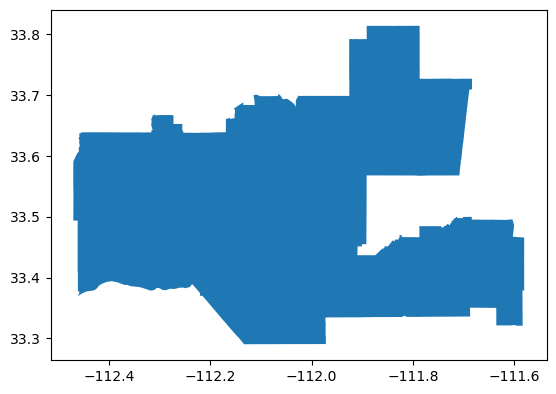

In [22]:
#plot the subsetted dataset to see if Phoenix was sucessfully filtered out
phoenix.plot()

### Phoenix subdivision map

Now that we have filtered for the data we want, let's map out Phoenix on top of a map to visually see how much area it spans.

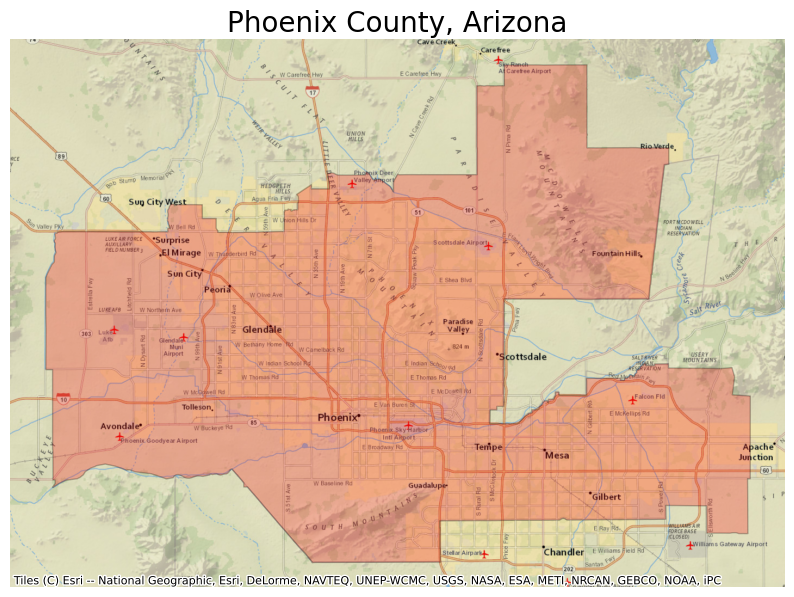

In [46]:
#create a map with Phoenix outline on top
# create axis with plot
ax = (phoenix.to_crs(epsg=3857)
      .plot(figsize=(10, 10), 
            alpha=0.25, 
            edgecolor="k",
            color = "red")
      )

# add NatGeo basemap from contextily
ctx.add_basemap(ax, source=ctx.providers.Esri.NatGeoWorldMap)

# update axes
ax.set_title("Phoenix County, Arizona", fontdict={"fontsize": "20"})
ax.set_axis_off()

#save map into image folder
plt.savefig('images/phoenix_county.png', bbox_inches='tight',  dpi=100)

We can see above that almost all of Phoenix county is in developed land. 

### Percentage of BII above .75
Since we are interested in seeing how the BII has changed over the years, let's go ahead and calculate the BII for the years we are interested in. 

*Note*: I have commented out the self checks that have helped me visualize what I have done. I encourage you to uncomment them to also see the output of each code.

In [44]:
#Percentage of BII over 0.75 for 2020:
#create into raster by filtering to the raster asset
phoenix_raster_2020 = rioxr.open_rasterio(item_2020.assets['data'].href)
#phoenix_raster_2020

#reproject phoenix crs to phoenix raster crs
phoenix = phoenix.to_crs(phoenix_raster_2020.rio.crs)
#print(phoenix.crs == phoenix_raster_2020.rio.crs)

#clip raster to Phoenix polygon
phoenix_raster_2020 = phoenix_raster_2020.rio.clip(phoenix['geometry'])
#phoenix_raster_2020.plot()

#find BII that are above 0.75
phoenix_75_2020 = (phoenix_raster_2020 >= .75)
#convert true and false into boolean
phoenix_75_2020_int = phoenix_75_2020.astype(int)
#phoenix_75_2020_int.plot()

#find the count and sum to be able to find the percentage:
#count
count_phoenix_2020 = phoenix_75_2020_int.count()
#print(count_phoenix_2020)
#sum
sum_phoenix_2020 = phoenix_75_2020_int.sum()
#print(sum_phoenix_2020)

#find percentage of BII over 0.75
phoenix_percentage_2020 = (sum_phoenix_2020/count_phoenix_2020)*100
print(phoenix_percentage_2020)

<xarray.DataArray ()>
array(3.8092763)
Coordinates:
    spatial_ref  int64 0


In [45]:
#create into raster by filtering to the raster asset
marisopa_raster_2017 = rioxr.open_rasterio(item_2017.assets['data'].href)
#marisopa_raster_2017

#clip raster to Phoenix county
marisopa_raster_2017 = marisopa_raster_2017.rio.clip(phoenix['geometry'])
#marisopa_raster_2017.plot()

#find BII that are above 0.75
marisopa_75_2017 = (marisopa_raster_2017 >= .75)
#convert true and false into boolean
marisopa_75_2017_int = marisopa_75_2017.astype(int)
#marisopa_75_2017_int.plot()

#find the count and sum to be able to find the percentage:
#count
count_marisopa_2017 = marisopa_75_2017_int.count()
#print(count_marisopa_2017)
#sum
sum_marisopa_2017 = marisopa_75_2017_int.sum()
#print(sum_marisopa_2017)

#find percentage of BII over 0.75
marisopa_percentage_2017 = (sum_marisopa_2017/count_marisopa_2017)*100
print(marisopa_percentage_2017)

<xarray.DataArray ()>
array(4.18126375)
Coordinates:
    spatial_ref  int64 0


<Axes: >

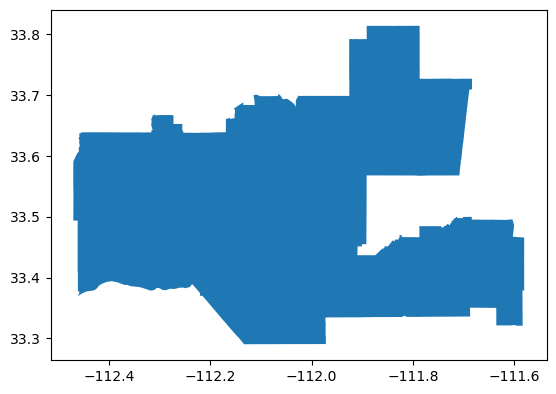

In [89]:
print(phoenix.crs)
print(phoenix_raster.rio.crs)

EPSG:4269
EPSG:4326


In [90]:
#reproject phoenix crs to phoenix raster crs
phoenix = phoenix.to_crs(phoenix_raster.rio.crs)
print(phoenix.crs == phoenix_raster.rio.crs)
print(phoenix.crs)

True
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


In [91]:
print(phoenix.type)
print(phoenix_raster.dtype)

10    Polygon
dtype: object
float32


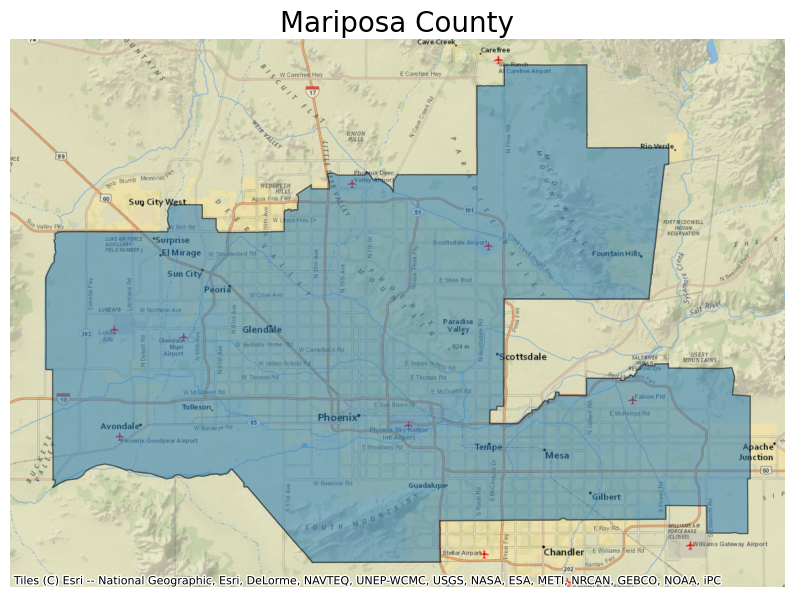

In [92]:
#create a map with mariposa county on top
# create axis with plot
ax = (phoenix.to_crs(epsg=3857)
      .plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
      )

# add NatGeo basemap from contextily
ctx.add_basemap(ax, source=ctx.providers.Esri.NatGeoWorldMap)

# update axes
ax.set_title("Mariposa County", fontdict={"fontsize": "20"})
ax.set_axis_off()



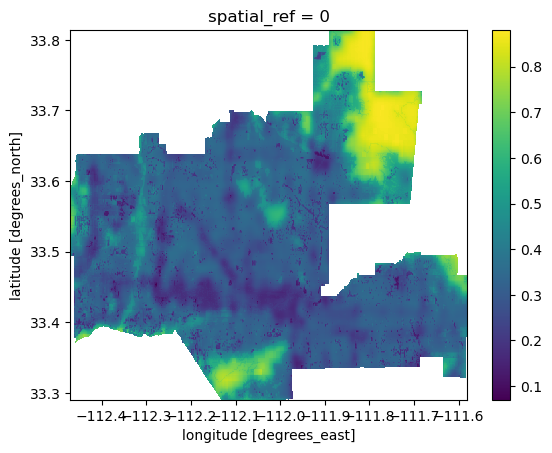

In [93]:
phoenix_clipped = phoenix_raster.rio.clip(phoenix['geometry'])
phoenix_clipped.plot()

In [94]:
#subset for the first item for 2020
item_2020 = items[0]
item_2020

id: bii_2020_34.74464974521749_-115.38597824385106_cog
"bbox: [-115.3859782, 27.565314, -108.2066425, 34.7446497]"
datetime: None
proj:epsg: 4326
"proj:shape: [7992, 7992]"
end_datetime: 2020-12-31T23:59:59Z
"proj:transform: [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0]"
start_datetime: 2020-01-01T00:00:00Z
https://stac-extensions.github.io/projection/v1.0.0/schema.json
https://stac-extensions.github.io/raster/v1.1.0/schema.json
https://stac-extensions.github.io/version/v1.1.0/schema.json


In [95]:
#create into raster
marisopa_raster_2020 = rioxr.open_rasterio(item_2020.assets['data'].href)
marisopa_raster_2020

<xarray.DataArray (band: 1, y: 7992, x: 7992)>
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57 27.57
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

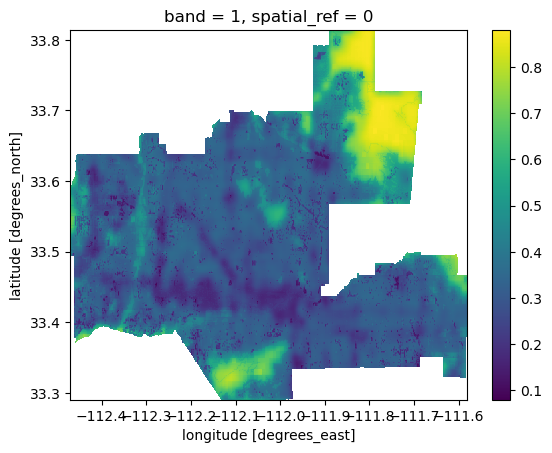

In [96]:
#clip raster to Phoenix, Marisopa 
marisopa_raster_2020 = marisopa_raster_2020.rio.clip(phoenix['geometry'])
marisopa_raster_2020.plot()

In [97]:
#print(marisopa_raster_2020.dims, marisopa_raster_2020.coords,'\n')

# remove length 1 dimension (band)
#marisopa_raster_2020 = marisopa_raster_2020.squeeze()
#print(marisopa_raster_2020.dims, marisopa_raster_2020.coords,'\n')

# remove coordinates associated to band
#marisopa_raster_2020 = marisopa_raster_2020.drop('band')
#print(marisopa_raster_2020.dims, marisopa_raster_2020.coords)

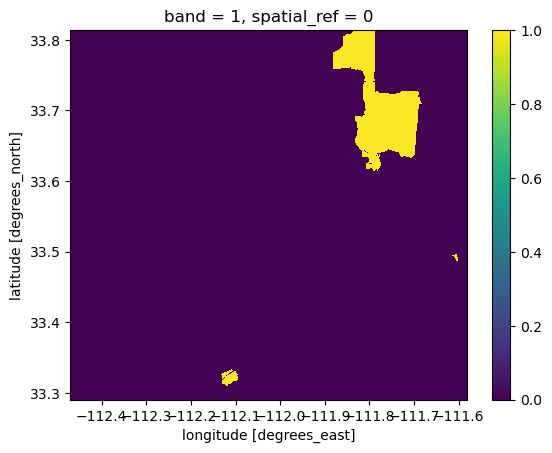

In [98]:
#find information that are above 75%
marisopa_75_2020 = (marisopa_raster_2020 >= .75)
#convert true and false into 0 and 1 and see what it looks like
marisopa_75_2020_int = marisopa_75_2020.astype(int)
marisopa_75_2020_int.plot()

In [158]:
#find the percentage of each spot:
count_marisopa_2020 = marisopa_75_2020_int.count()
print(count_marisopa_2020)
sum_marisopa_2020 = marisopa_75_2020_int.sum()
print(sum_marisopa_2020)

<xarray.DataArray ()>
array(577170)
Coordinates:
    spatial_ref  int64 0
<xarray.DataArray ()>
array(21986)
Coordinates:
    spatial_ref  int64 0


In [159]:
marisopa_percentage_2020 = (sum_marisopa_2020/count_marisopa_2020)*100
marisopa_percentage_2020

<xarray.DataArray ()>
array(3.8092763)
Coordinates:
    spatial_ref  int64 0

In [101]:
#item for 2017
item_2017 = items[3]
item_2017
#create into raster
marisopa_raster_2017 = rioxr.open_rasterio(item_2017.assets['data'].href)
marisopa_raster_2017

<xarray.DataArray (band: 1, y: 7992, x: 7992)>
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57 27.57
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

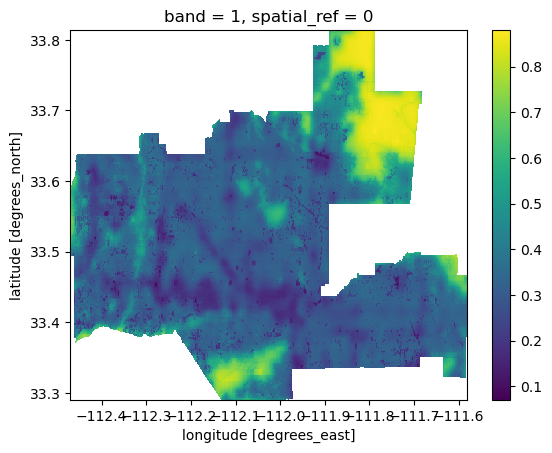

In [102]:
#clip raster to Phoenix, Marisopa 
marisopa_raster_2017 = marisopa_raster_2017.rio.clip(phoenix['geometry'])
marisopa_raster_2017.plot()

In [103]:
#print(marisopa_raster_2017.dims, marisopa_raster_2017.coords,'\n')

# remove length 1 dimension (band)
#marisopa_raster_2017 = marisopa_raster_2017.squeeze()
#print(marisopa_raster_2017.dims, marisopa_raster_2017.coords,'\n')

# remove coordinates associated to band
#marisopa_raster_2017 = marisopa_raster_2017.drop('band')
#print(marisopa_raster_2017.dims, marisopa_raster_2017.coords)

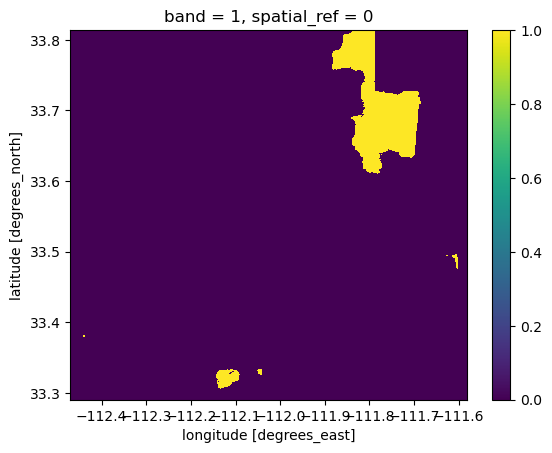

In [104]:
#find information that are above 75%
marisopa_75_2017 = (marisopa_raster_2017 >= .75)
#convert true and false into 0 and 1 and see what it looks like
marisopa_75_2017_int = marisopa_75_2017.astype(int)
marisopa_75_2017_int.plot()

In [160]:
#find the percentage of each spot:
count_marisopa_2017 = marisopa_75_2017_int.count()
print(count_marisopa_2017)

sum_marisopa_2017 = marisopa_75_2017_int.sum()
print(sum_marisopa_2017)

<xarray.DataArray ()>
array(577170)
Coordinates:
    spatial_ref  int64 0
<xarray.DataArray ()>
array(24133)
Coordinates:
    spatial_ref  int64 0


In [162]:
marisopa_percentage_2017 = (sum_marisopa_2017/count_marisopa_2017)*100
print(marisopa_percentage_2017)

<xarray.DataArray ()>
array(4.18126375)
Coordinates:
    spatial_ref  int64 0


In [176]:
marisopa_difference = marisopa_75_2017_int - marisopa_75_2020_int
marisopa_difference = marisopa_difference == 1
marisopa_difference = marisopa_difference.astype(int)

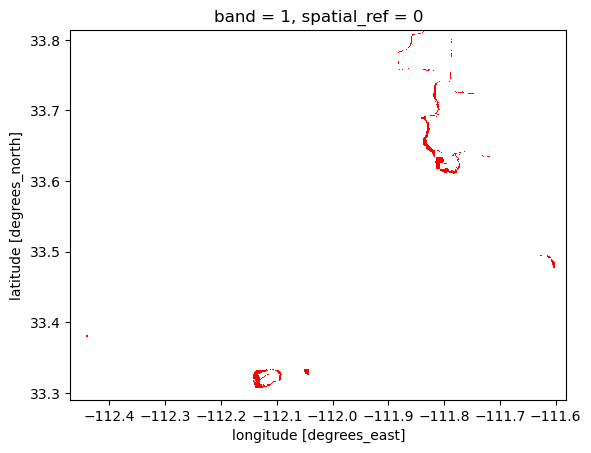

In [177]:
# Create a custom colormap with two distinct colors
colors = ['none', 'red']  # Specify colors for your two categories
cmap = plt.cm.colors.ListedColormap(colors)

marisopa_difference.plot(cmap=cmap, add_colorbar = False)

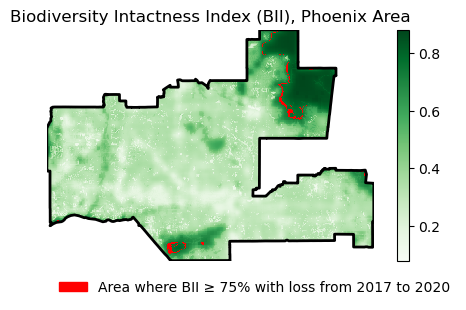

In [236]:
fig, ax = plt.subplots(figsize = (6,3))

ax.axis('off')


marisopa_raster_2020.plot(ax = ax, 
                          cmap = "Greens") ##HOW DO I ADD LABEL FOR SCALE ON THE SIDE

marisopa_difference.plot(cmap=cmap, add_colorbar = False)

marisopa_difference_patch = mpatches.Patch(color='red',
                              label='Area where BII ≥ 75% with loss from 2017 to 2020')

phoenix.plot(ax = ax, color = 'none', edgecolor = 'black', linewidth = 2)

ax.set_title("Biodiversity Intactness Index (BII), Phoenix Area")
ax.legend(handles = [marisopa_difference_patch], frameon=False, loc='lower left', bbox_to_anchor= (0, -0.2))

plt.show()

In [ ]:
#find information that are above 75%
marisopa_75_2017 = (marisopa_raster_2017 >= .75)
#convert true and false into 0 and 1
marisopa_75_2017.astype(int)

In [ ]:
# bounding box as geodataframe
#phoenix_bounds = gpd.GeoDataFrame(geometry=[phoenix]) 

#clipped_mask, = mask(dataset=phoenix_raster.rio.to_rasterio(), shapes=[phoenix], crop=True)

In [ ]:
# clip raster to bounding box
#sb = sb.rio.clip_box(*box_df.to_crs(sb.rio.crs).total_bounds)

In [ ]:
phoenix_clipped = phoenix_raster.rio.clip(*phoenix.geometry, phoenix.crs)

phoenix_clipped.plot()
phoenix.plot()

In [ ]:
#you can do array minus array